In [1]:
import berrylib.util as util
util.setup_nb()

In [2]:
from berrylib.constants import Y_I2, N_I2
import berrylib.fast_inla as fast_inla
import berrylib.mcmc as mcmc
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

y=Y_I2
n=N_I2

fi = fast_inla.FastINLA(sigma2_n=15)

/Users/tbent/.mambaforge/envs/imprint2/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/imprint2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def conditional_mu(mu, cov, i, x):
    """Return the conditional mean of a multivariate normal given a particular arm value.
    
    https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions
    """
    cov12 = np.delete(cov[i], i)
    cov22 = cov[i, i]
    mu1 = np.delete(mu, i)
    mu2 = mu[i]
    mu_cond = mu1 + cov12 / cov22 * (x - mu2)
    return mu_cond

In [4]:
mcmc_results = []
for sig_idx in range(fi.sigma2_n):
    mcmc_results.append(mcmc.mcmc_berry(
        np.stack((y[-1:], n[-1:]), axis=-1),
        fi.logit_p1,
        fi.thresh_theta,
        dtype=np.float64,
        n_samples=200000,
        sigma2_val=fi.sigma2_rule.pts[sig_idx]
    ))

In [5]:
mcmc_arm_marg = mcmc.mcmc_berry(
    np.stack((y[-1:], n[-1:]), axis=-1),
    fi.logit_p1,
    fi.thresh_theta,
    dtype=np.float64,
    n_samples=200000,
)

In [21]:
def cond_laplace(t_i, sigma2_n):
    fi = fast_inla.FastINLA(sigma2_n=sigma2_n)
    data = np.stack((y, n), axis=-1)
    sigma2_post, _, theta_max, theta_sigma, hess_inv = fi.numpy_inference(data)
    arm_idx = 0
    theta_max_cond = np.empty((fi.sigma2_n, t_i.pts.shape[0], 4))
    theta_sigma_cond = np.empty((fi.sigma2_n, t_i.pts.shape[0], 4))
    p_t0_g_sig2_y = np.empty((fi.sigma2_n, t_i.pts.shape[0]))
    for sig_idx in range(fi.sigma2_n):
        for i, t0_val in enumerate(t_i.pts):
            cond_mu = conditional_mu(theta_max[-1, sig_idx], -hess_inv[-1, sig_idx], arm_idx, t0_val)

            theta_max_cond[sig_idx, i, 0] = t0_val
            theta_max_cond[sig_idx, i, 1:] = cond_mu

            exp_theta_adj = np.exp(theta_max_cond[sig_idx, i] + fi.logit_p1)
            C = 1.0 / (exp_theta_adj + 1)
            hess = fi.neg_precQ[sig_idx].copy()
            hess[np.arange(4), np.arange(4)] -= (n[-1] * exp_theta_adj * (C**2))

            cond_hess_inv = np.linalg.inv(hess)
            theta_sigma_cond[sig_idx, i] = np.sqrt(np.diagonal(-cond_hess_inv))

            logjoint = fi.model.log_joint(fi, data[-1:], theta_max_cond[None, sig_idx, i])[0,sig_idx]
            p_t0_g_sig2_y[sig_idx, i] = logjoint + 0.5 * np.log(np.linalg.det(-cond_hess_inv[1:, 1:]))
    laplace = np.exp(p_t0_g_sig2_y)
    laplace /= np.sum(laplace * t_i.wts[None,:], axis=1)[:, None]
    laplace_integral = np.sum(laplace * (sigma2_post[-1] * fi.sigma2_rule.wts)[:, None], axis=0)
    return theta_max, theta_sigma, laplace, laplace_integral, hess_inv

In [24]:
t_i = util.simpson_rule(101, -15, 2)
theta_max, theta_sigma, laplace, laplace_integral, hess_inv = cond_laplace(t_i, fi.sigma2_n)

In [33]:
np.sum(laplace[sig_idx] * t_i.wts)

0.9999999999999998

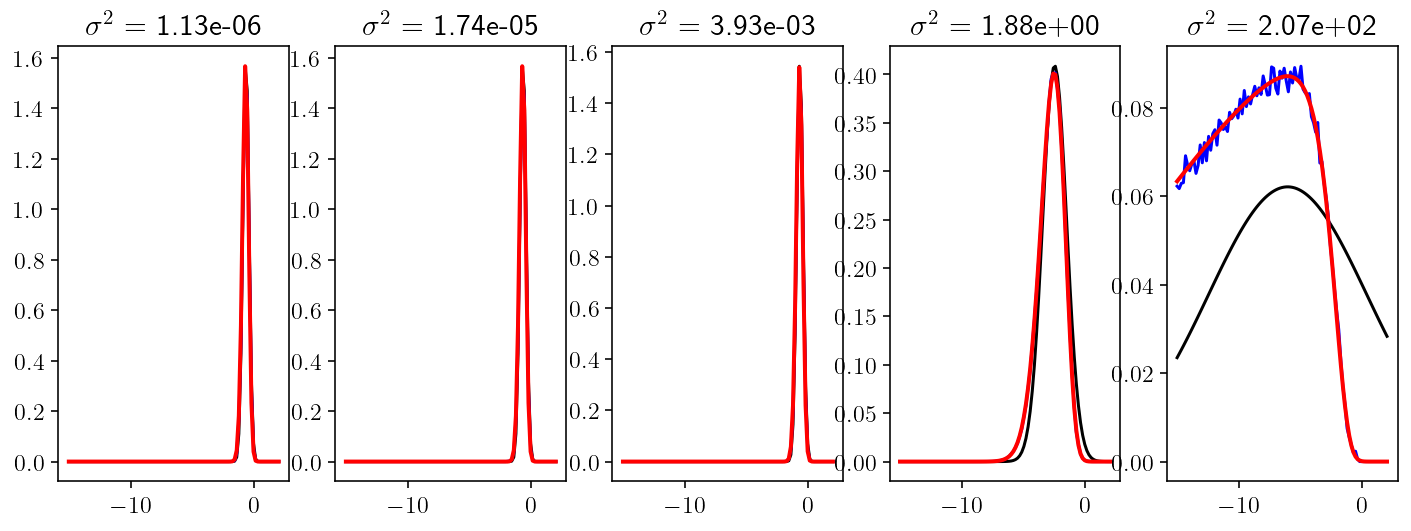

In [29]:
arm_idx = 0
plt.figure(figsize=(12, 4))
for i, sig_idx in enumerate(range(fi.sigma2_n)[::3]):
    mcmc_arm = mcmc_results[sig_idx]["x"][0]["theta"][0, :, arm_idx]
    mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, t_i.pts, t_i.wts)
    gaussian = scipy.stats.norm.pdf(t_i.pts, theta_max[-1, sig_idx, 0], theta_sigma[-1, sig_idx, 0])

    plt.subplot(1,5,1 + i)
    plt.title(f'$\sigma^2$ = {fi.sigma2_rule.pts[sig_idx]:5.2e}')
    plt.plot(t_i.pts, gaussian, 'k-')
    plt.plot(t_i.pts, mcmc_p_ti_g_y, 'b-')
    plt.plot(t_i.pts, laplace[sig_idx], 'r-', linewidth=2.0)
plt.show()

In [13]:
mcmc_arm = mcmc_arm_marg["x"][0]["theta"][0, :, arm_idx]
mcmc_p_ti_g_y = mcmc.calc_pdf(mcmc_arm, t_i.pts, t_i.wts)

In [14]:
from scipy.special import logit

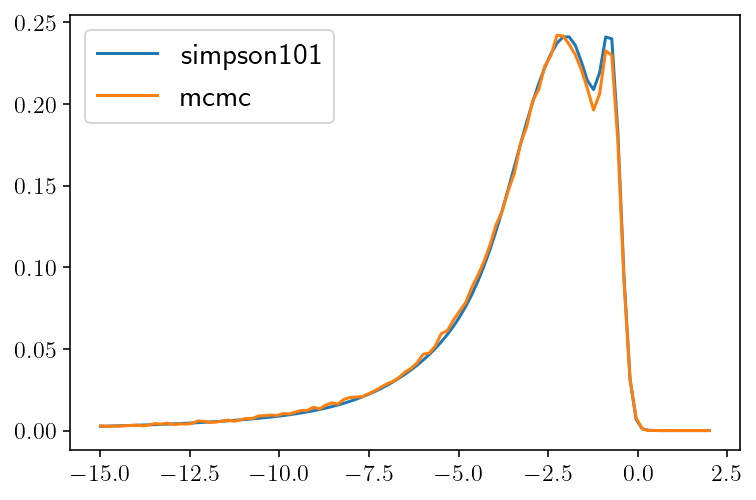

In [16]:
t_i = util.simpson_rule(101, -15, 2)
_, _, _, laplace_integral = cond_laplace(t_i, 20)
plt.plot(t_i.pts, laplace_integral, label=f'simpson101')
plt.plot(t_i.pts, mcmc_p_ti_g_y, label='mcmc')

# t_i = util.gauss_rule(20, -15, 2)
# _, _, _, laplace_integral = cond_laplace(t_i, 20)
# plt.plot(t_i.pts, laplace_integral, label=f'gauss20')

# plt.vlines([logit(0.1) - logit(0.3), logit(0.2) - logit(0.3)], 0, 0.25, 'k')

plt.legend()
plt.show()

In [52]:
logratio = np.where((laplace_integral == 0) | (mcmc_p_ti_g_y == 0), 0, np.log(mcmc_p_ti_g_y / laplace_integral))
laplace_integral * logratio

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_93795/2334663690.py:1: RuntimeWarning: divide by zero encountered in log
  logratio = np.where((laplace_integral == 0) | (mcmc_p_ti_g_y == 0), 0, np.log(mcmc_p_ti_g_y / laplace_integral))


array([ 0.00808466,  0.00823673,  0.00846883,  0.00866434,  0.0091247 ,  0.00924698,  0.00940639,
        0.009707  ,  0.00998067,  0.01008655,  0.01044141,  0.01096357,  0.0110378 ,  0.01160499,
        0.01168689,  0.01236486,  0.01253169,  0.01315615,  0.0136225 ,  0.0137978 ,  0.01465845,
        0.01508465,  0.01545579,  0.01601403,  0.01644582,  0.01739946,  0.01783799,  0.01849625,
        0.01926984,  0.01966735,  0.02082234,  0.02105716,  0.02242464,  0.02259646,  0.02359445,
        0.02401035,  0.0250302 ,  0.02601849,  0.02626957,  0.02724527,  0.02752801,  0.02902035,
        0.02909548,  0.02901659,  0.029456  ,  0.03157669,  0.031889  ,  0.03081393,  0.03052496,
        0.03242573,  0.03189893,  0.03268513,  0.0312852 ,  0.02969373,  0.0310881 ,  0.02878409,
        0.02918009,  0.02570454,  0.02241671,  0.02050793,  0.01079566,  0.00235733, -0.00814336,
       -0.02054291, -0.043557  , -0.06529286, -0.09204244, -0.11304275, -0.16159005, -0.18907644,
       -0.23065481, 

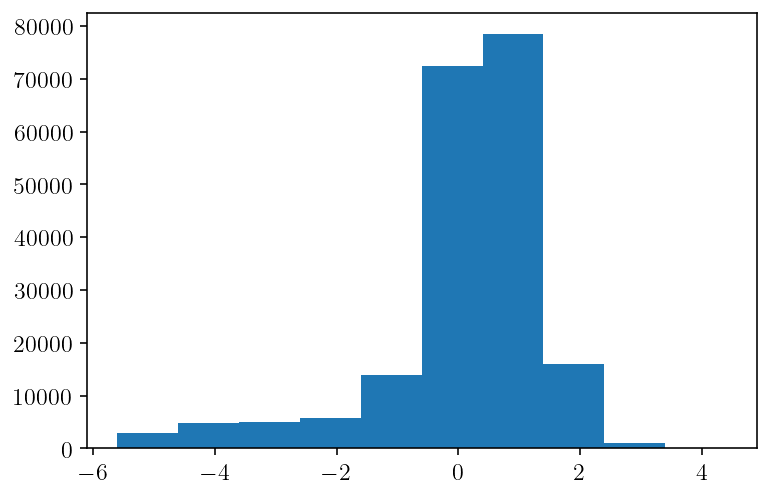

In [42]:
plt.hist(np.log10(mcmc_arm_marg['x'][0]['sigma2'][0]))
plt.show()

In [43]:
import inlaw
from inlaw.berry_model import berry_model

In [ ]:
inlaw.FullLaplace(berry_model(4))